# Baby names analysis

### Take care of all the imports and define functions to get and load data

In [1]:
__author__ = 'eladg'
import urllib.request
import zipfile
import glob
import pandas as pd
import seaborn as sns
import scipy
from sklearn.decomposition.pca import PCA
import matplotlib.pylab as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0)

## helper function to download baby name data
def dl_data():
    urllib.request.urlretrieve('http://www.ssa.gov/oact/babynames/state/namesbystate.zip', 'namesbystate.zip')
    with zipfile.ZipFile('namesbystate.zip', 'r') as z:
        z.extractall('./')
## helper function to load all data files in archives
def load_data():
    flist = glob.glob('*.TXT')
    df = pd.DataFrame()

    ls = []
    for f in flist:
        ls.append(pd.read_csv(f, header=None, names=['State', 'Gender', 'Year', 'Name', 'Count']))

    return pd.concat(ls)


# dl_data()
df = load_data()

### Calculate the all-time most popular name

In [2]:
grouped_by_name = df.groupby('Name')  ## Group data frame by name
name_count = grouped_by_name['Count'].sum() ##sum counts by name (across gender, state, year)
name_count.sort(inplace=True,ascending=False) ##Sort the counts
all_time_leader = name_count.index[0] ## All-time leader is the first in the array
print("All-time leader: %s" % all_time_leader)

All-time leader: James


### Calculate most ambiguous name

In [3]:
year_list = [2013, 1945] ## years to calculate ambigous names for
most_ambiguous = []
for year in year_list:
    ## Group M and F separately
    grouped_by_name_f = df[(df['Year'] == year) & (df['Gender'] == 'F')][['Name','Count']].groupby(['Name'])
    grouped_by_name_m = df[(df['Year'] == year) & (df['Gender'] == 'M')][['Name','Count']].groupby(['Name'])
    ## Count name by gender separately
    name_gender_count_f = grouped_by_name_f['Count'].sum()
    name_gender_count_m = grouped_by_name_m['Count'].sum()
    ##Combine the counts per gender
    combi = pd.concat([name_gender_count_f,name_gender_count_m], axis=1) 
    combi.fillna(0, inplace=True) # When the name is missing for one gender replace NaN with 0
    #Estimate ambiguity by calculating how close the ratio of the M and F counts is to 0
    ambiguity = ((combi.ix[:,0] / (combi.ix[:,0] + combi.ix[:,1])) - 0.5).abs() 
    ambiguity.sort()
    most_ambiguous.append(ambiguity[ambiguity==0].index.values) # Make a list of ambiguous name

    print('Ambiguous names for %d: %s' % (year, most_ambiguous[-1]))
#     tmp = df[(df['Year']==year) & (df['Name']==most_ambiguous[-1][0])].groupby('Gender')
#     tmp['Count'].sum()

Ambiguous names for 2013: ['Nikita' 'Cree' 'Sonam' 'Arlin' 'Devine']
Ambiguous names for 1945: ['Maxie']


### Calculate biggest increase/decrease in count since 1980

In [4]:
## Largest increase/decrease since 1980
df1980 = df[df['Year']==1980] ##only take values for 1980
df2014 = df[df['Year']==2014] ##only take most current values
grouped1980 = (df1980.groupby('Name'))['Count'].sum() ## For each year count the total number of names
grouped2014 = (df2014.groupby('Name'))['Count'].sum()
## combine the two data frames, only include names which appear in both
joint = pd.concat([grouped2014, grouped1980], axis=1, join='inner') 
## Calculate pct increase
pct_incr = ((joint.ix[:,0] - joint.ix[:,1])/joint.ix[:,1]) 
pct_incr.sort(inplace=True,ascending=False)
biggest_increase = (pct_incr.index[0], pct_incr[0]*100)
## Calculate pct decreass
pct_decr = (joint.ix[:,1] - joint.ix[:,0])/joint.ix[:,1]
pct_decr.sort(inplace=True,ascending=False)
biggest_decrease = (pct_decr.index[0], pct_decr[0]*100)

print('Biggest increase: %s (%d%%)' % biggest_increase)
print('Biggest decrease: %s (%d%%)' % biggest_decrease)

Biggest increase: Colton (126600%)
Biggest decrease: Latoya (99%)


## Examine how the use of ambiguous names relates to voting in 2012 presidential election
In this version I weight ambiguity by name count

In [6]:
## Ambiguity by state
year = 2012 #latest presidential elections
## Group M and F separately
grouped_by_name_f = df[(df['Year']==year) & (df['Gender'] == 'F')][['State','Name','Count']].groupby(['State','Name'])
grouped_by_name_m = df[(df['Year']==year) & (df['Gender'] == 'M')][['State','Name','Count']].groupby(['State','Name'])
## Count name by gender separately
name_gender_count_f = grouped_by_name_f.sum()
name_gender_count_m = grouped_by_name_m.sum()
combi = pd.merge(name_gender_count_f.reset_index(), name_gender_count_m.reset_index(),on=['State','Name'],how='outer')

Correlation coefficient = -0.25 (p = 0.07)


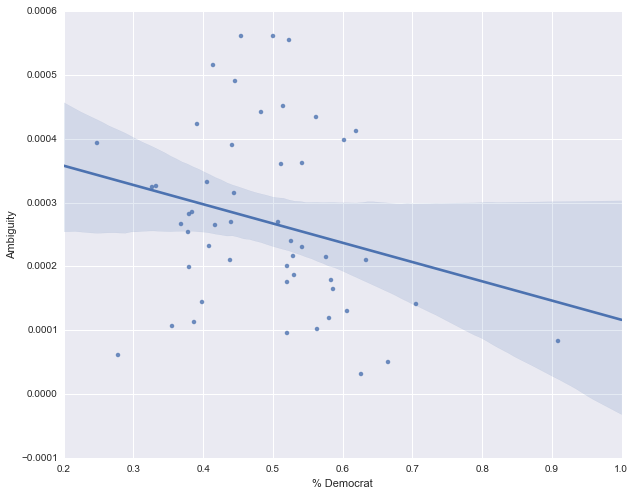

In [16]:
## Combine the counts into one data frame
combi = pd.merge(name_gender_count_f.reset_index(), name_gender_count_m.reset_index(),on=['State','Name'],how='outer')
combi.fillna(0, inplace=True)
## clculate ambiguity on a scale of 0 to 1
ambiguity = combi['Count_x']/(combi['Count_x'] + combi['Count_y']) ## Take the ratio of female to sum
## first convert everything to 0-0.5 and then multiply by 2 (to get 0-1)
combi['Ambiguity'] = 2*(pd.concat([ambiguity, 1-ambiguity],axis=1)).min(axis=1)
totalCount = combi.ix[:,2] + combi.ix[:,3];

gObj = df.groupby('State')
totalCountPerState = gObj['Count'].sum()
combi = pd.merge(combi,totalCountPerState.reset_index(),on='State')
combi['Ambiguity'] = combi['Ambiguity']*(combi['Count_x'] + combi['Count_y'])/combi['Count']

avg_ambiguity = combi[['State', 'Ambiguity']].groupby('State').sum()
election_df = pd.read_pickle('election_df.pkl') ##load election results dataframe
election_ambi = election_df.join(avg_ambiguity,on='State',how='inner') #join election results and ambiguity by state
##Plot relationship between %democrate votes and mean ambiguity
ax = sns.regplot(election_ambi['D_pct'], election_ambi['Ambiguity'])
ax.set_xlabel('% Democrat')
plt.xlabel('% Democrat')
corrco = scipy.stats.pearsonr(election_ambi['D_pct'], election_ambi['Ambiguity'])
print('Correlation coefficient = %0.2f (p = %0.2f)' % corrco)

Now What happens if I remove DC from the analysis...

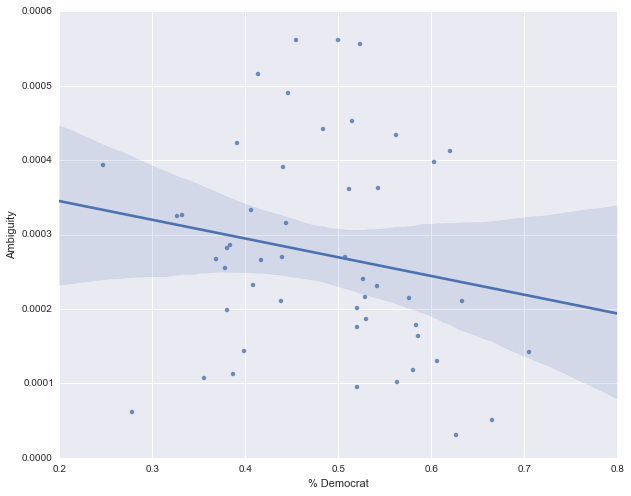

In [15]:
ax = sns.regplot(election_ambi['D_pct'][election_ambi['State']!='DC'], election_ambi['Ambiguity'][election_ambi['State']!='DC'])
scipy.stats.pearsonr(election_ambi['D_pct'][election_ambi['State']!='DC'], election_ambi['Ambiguity'][election_ambi['State']!='DC'])
plt.xlabel('% Democrat')

## Use dimension reduction to see if states cluster

In [10]:
n_names = 1 ## only use top name (most data)
top_names = name_count.index[0:n_names]
# df_top = df[df['Name'].isin(top_names.values)][['State', 'Year', 'Count']]
df_top = df[(df['Name']=='James') & (df['Gender']=='M')][['State', 'Year', 'Count']] ## restrict analysis to top name
df_top = df_top.reset_index()
df_top.drop('index',axis=1,inplace=True)
X = df_top.pivot(index='Year',columns='State',values='Count')
X.fillna(0,inplace=True)
X = X.T

In [13]:
pca = PCA(n_components=2, whiten=True)
pca.fit(X)
X_reduced = pca.transform(X)
print('Explained variance by the first two PCs:', pca.explained_variance_ratio_)

Explained variance by the first two PCs: [ 0.92324571  0.05733323]


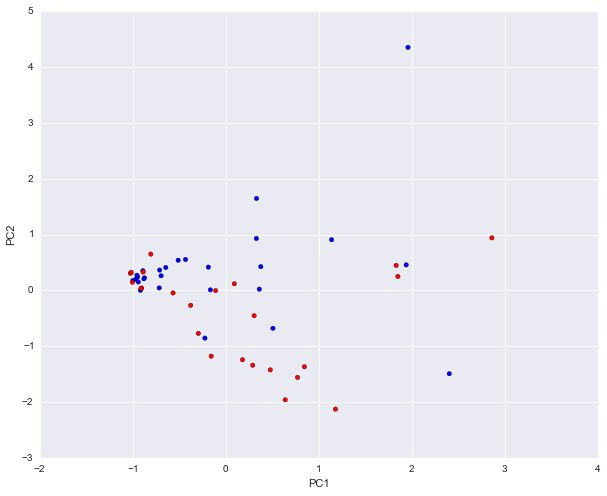

In [14]:
## Now plot the projection onto the first two PCs
colors = ((election_df['D_pct']<0.5).values).astype(float)
plt.scatter(X_reduced[:,0],X_reduced[:,1], c=colors, cmap='bwr')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.savefig('pca.png',dpi=300)

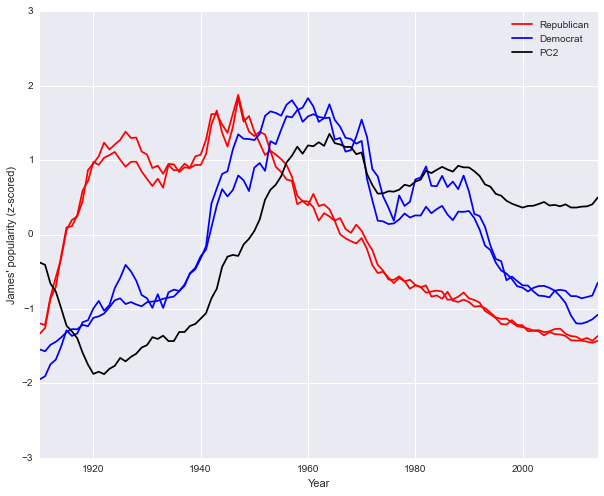

In [22]:
#Show what the trends look like for the states with the highest and smallest PC2 values
pc2_sorted = (X_reduced[:,1]).argsort()
pc2 = (pca.components_)[1,:]
tmp = (X.values)[pc2_sorted[[0,1]],:]
tmp = (scipy.stats.mstats.zscore(tmp,axis=1))
handlesR = plt.plot(range(1910,2015), tmp.T, 'r', label='Republican')
tmp = (X.values)[pc2_sorted[[-1,-2]],:]
tmp = (scipy.stats.mstats.zscore(tmp,axis=1))
handlesD = plt.plot(range(1910,2015), tmp.T, 'b', label='Democrat')
handlePC = plt.plot(range(1910,2015), scipy.stats.mstats.zscore(pc2), 'k', label='PC2')
plt.xlabel('Year')
plt.ylabel("James' popularity (z-scored)")
plt.legend(handles = [handlesR[0], handlesD[0], handlePC[0]])
plt.xlim(1910,2014)
plt.ylim(-3,3)
plt.savefig('princomps.png',dpi=300)

# Now lets plot stuff on a map

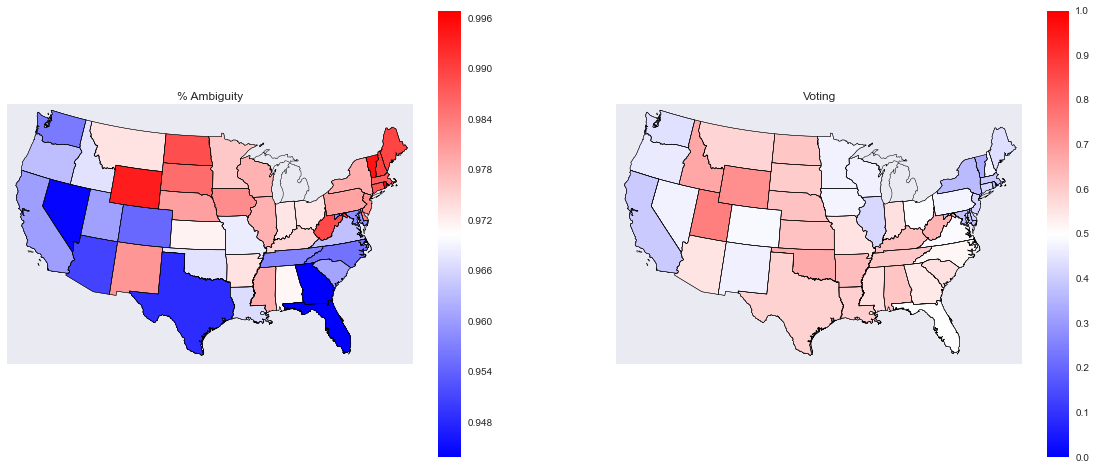

In [47]:
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
from matplotlib.patches import Polygon
from matplotlib.collections import PatchCollection
import numpy as np

fig = plt.figure(figsize=(20.0, 8.0))
axAmbi = fig.add_subplot(121)
axAmbi.set_title("% Ambiguity")
# create the map
map = Basemap(llcrnrlon=-119,llcrnrlat=22,urcrnrlon=-64,urcrnrlat=49,
        projection='lcc',lat_1=33,lat_2=45,lon_0=-95)
# load the shapefile, use the name 'states'
map.readshapefile('states', name='states', drawbounds=True)


axVote = fig.add_subplot(122)
axVote.set_title("Voting")
# create the map
map = Basemap(llcrnrlon=-119,llcrnrlat=22,urcrnrlon=-64,urcrnrlat=49,
        projection='lcc',lat_1=33,lat_2=45,lon_0=-95)
# load the shapefile, use the name 'states'
map.readshapefile('states', name='states', drawbounds=True)


# collect the state names from the shapefile attributes so we can
# look up the shape obect for a state by it's name
state_abbr = []
for shape_dict in map.states_info:
    state_abbr.append(shape_dict['STATE_ABBR'])


patchesAmbi = []
colAmbi = [];
patchesVote = []
colVote = [];
for state in state_abbr:
    seg = map.states[state_abbr.index(state)]
    currVal = 1 - election_ambi[election_ambi['State']==state]['D_pct'].values[0]
    colVote.append(currVal)
    poly = Polygon(seg,edgecolor='black')
    patchesVote.append(poly)
    
    currVal = 1 - election_ambi[election_ambi['State']==state]['Ambiguity'].values[0]*100
    colAmbi.append(currVal)
    poly = Polygon(seg,edgecolor='black')
    patchesAmbi.append(poly)
    
p = PatchCollection(patchesAmbi, cmap=plt.get_cmap('bwr'))
p.set_array(np.array(colAmbi))
axAmbi.add_collection(p)
plt.subplot(1, 2, 2)
plt.colorbar(axAmbi.get_children()[3], ax = axAmbi)

p = PatchCollection(patchesVote, cmap=plt.get_cmap('bwr'))
p.set_array(np.array(colVote))
p.set_clim(0,1)
axVote.add_collection(p)
plt.colorbar(axVote.get_children()[3], ax = axVote)


A worse way to do it

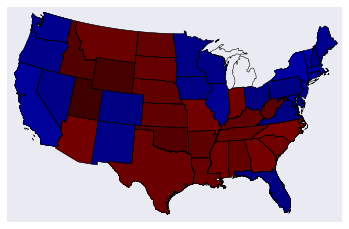

In [35]:
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
from matplotlib.patches import Polygon

# create the map
map = Basemap(llcrnrlon=-119,llcrnrlat=22,urcrnrlon=-64,urcrnrlat=49,
        projection='lcc',lat_1=33,lat_2=45,lon_0=-95)

# load the shapefile, use the name 'states'
map.readshapefile('states', name='states', drawbounds=True)

# collect the state names from the shapefile attributes so we can
# look up the shape obect for a state by it's name
state_abbr = []
for shape_dict in map.states_info:
    state_abbr.append(shape_dict['STATE_ABBR'])

ax = plt.gca() # get current axes instance
for state in state_abbr:
    seg = map.states[state_abbr.index(state)]
    currVal = election_ambi[election_ambi['State']==state]['D_pct'].values[0]
    if currVal<0.5:
        currCol = [currVal,0,0]
    else:
        currCol = [0,0,currVal]
    poly = Polygon(seg, facecolor=currCol,edgecolor='black')
    ax.add_patch(poly)

plt.show()